In [0]:
!pip install git+https://github.com/ElArkk/jax-unirep.git --upgrade
!pip install optuna
!pip install biopython
!pip install seaborn

  Cloning https://github.com/ElArkk/jax-unirep.git to /tmp/pip-req-build-e1rvybot
  Running command git clone -q https://github.com/ElArkk/jax-unirep.git /tmp/pip-req-build-e1rvybot
  Created wheel for jax-unirep: filename=jax_unirep-0.1-cp36-none-any.whl size=67744670 sha256=35ddeea160469cda2d0ee7c021c2648acb3481c1dea7367f9edccbf1abc2345a
  Stored in directory: /tmp/pip-ephem-wheel-cache-oui9tqfb/wheels/08/4d/ac/6e75862c118d1ad82122f410859524b20190ce7a821b76ffcd
Successfully built jax-unirep
  Found existing installation: jax-unirep 0.1
    Uninstalling jax-unirep-0.1:
      Successfully uninstalled jax-unirep-0.1


In [0]:
from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params_1900
from Bio import SeqIO
import pandas as pd
import glob
import os
from pathlib import Path
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LinearRegression, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import feather
import random

from google.colab import drive

drive.mount('/content/drive/')
gdrive_path = "/content/drive/My Drive/Colab Notebooks/UniRep/"
!ls "/content/drive/My Drive/Colab Notebooks/UniRep"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 2MS2_data_exploration_2.ipynb	 feathers
 2MS2_data_exploration.ipynb	 inputs
 2MS2_weights			 MS2_double_AA_additive_fitness.txt
 BLAC_data_exploration.ipynb	 MS2_double_AA_heat_fitness.txt
 blac_fitness.txt		 MS2_double_AA_mut_fitness.txt
 blac_seqs.txt			 MS2_double_AA_mut_seqs.txt
 BLAC_weights			 MS2_single_AA_mut_fitness.txt
 DE_notebook.ipynb		 MS2_single_AA_mut_seqs.txt
 DE_records			'old numpy files'
 double_mut_AAs_1.txt		 PETase_data_exploration.ipynb
 double_mut_AAs_2.txt		 PETase_mutant_fitness.txt
 double_mut_data.pkl		 PETase_mutant_seqs.txt
 double_mut_locs_1.txt		 PETase_weights
 double_mut_locs_2.txt


In [0]:
# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open(gdrive_path + name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data

# read sequence text file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_labeled_data(name):
    seqs = np.loadtxt(gdrive_path + name + '_seqs.txt', dtype='str')
    
    fitnesses = np.loadtxt(gdrive_path + name + '_fitness.txt')
    data = []
    for seq, fitness in zip(seqs, fitnesses):
        data.append([str(seq).strip(), fitness])
    
    return data

# save represented dataframe of features as feather
def save_reps(df, path):
  feather.write_dataframe(df, path + '.feather')
  print(path + '.feather', 'saved!')


# read represented dataframe of features as feather
def read_reps(path):
  return feather.read_dataframe(path + '.feather')


aa_to_int = {
  'M':1,
  'R':2,
  'H':3,
  'K':4,
  'D':5,
  'E':6,
  'S':7,
  'T':8,
  'N':9,
  'Q':10,
  'C':11,
  'U':12,
  'G':13,
  'P':14,
  'A':15,
  'V':16,
  'I':17,
  'F':18,
  'Y':19,
  'W':20,
  'L':21,
  'O':22, #Pyrrolysine
  'X':23, # Unknown
  'Z':23, # Glutamic acid or GLutamine
  'B':23, # Asparagine or aspartic acid
  'J':23, # Leucine or isoleucine
  'start':24,
  'stop':25,
}


def get_int_to_aa():
  return {value:key for key, value in aa_to_int.items()}


def _one_hot(x, k, dtype=np.float32):
  # return np.array(x[:, None] == np.arange(k), dtype)
  return np.array(x[:, None] == np.arange(k))


def aa_seq_to_int(s):
  """Return the int sequence as a list for a given string of amino acids."""
  # Make sure only valid aa's are passed
  if not set(s).issubset(set(aa_to_int.keys())):
    raise ValueError(
      f"Unsupported character(s) in sequence found:"
      f" {set(s).difference(set(aa_to_int.keys()))}"
    )

  return [aa_to_int[a] for a in s]


def aa_seq_to_onehot(seq):
  return 1*np.equal(np.array(aa_seq_to_int(seq))[:,None], np.arange(21)).flatten()
  

def multi_onehot(seqs):
  return np.stack([aa_seq_to_onehot(s) for s in seqs.tolist()])


def distance_matrix(N):
	distance_matrix = np.zeros((N,N))
	for i in range(N):
		for j in range(N):
			# distance_matrix[i,j]=1- ((abs(i-j)/N)**2)
			distance_matrix[i,j]= 1-(abs(i-j)/N)

	return distance_matrix


def confusion_matrix_loss(Y_test,Y_preds_test):

  N = len(Y_test)
  Y_rank_matrix = np.zeros((N,N))
  Y_preds_rank_matrix = np.zeros((N,N))
  for i in range(N):
    for j in range(N):

      if Y_test[i] > Y_test[j]:
        Y_rank_matrix[i,j] = 1
      elif Y_test[i] <= Y_test[j]:
        Y_rank_matrix[i,j] = 0
      if Y_preds_test[i] > Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 1
      elif Y_preds_test[i] <= Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 0
  confusion_matrix = ~(Y_preds_rank_matrix == Y_rank_matrix)
  # dist_mat = distance_matrix(N)
  # confusion_matrix = confusion_matrix*dist_mat
  loss = np.sum(confusion_matrix)/confusion_matrix.size

  return loss

...

## -----o-----o------o---- End of everything pre-DE -----o-----o------o----







...

# Load the functions and utilities needed to simulate DE

In [0]:

def get_top_model(df, alpha, train_batch_size):

  rand_state_num = 1717

  np.random.seed(rand_state_num)

  rndperm = np.random.permutation(df.shape[0])

  X_train = df.loc[rndperm[:train_batch_size], df.columns[2:]]
  Y_train = df.loc[rndperm[:train_batch_size], "fitness"]

  kfold = KFold(n_splits=10, random_state=rand_state_num, shuffle=True)

  return RidgeCV(alphas=alpha, cv=kfold).fit(X_train, Y_train)

def init_by_rep(df, alpha_val, N, param_file):

  if param_file == None:
    params = load_params_1900(None)
    DE_model = get_top_model(df, [alpha_val], N) # choose unirep representation, alpha=1e-3, and 96 training mutants


  else: # if we want to use an evotuned representation:
    params = load_params_1900(gdrive_path + param_file)
    DE_model = get_top_model(df, [alpha_val], N) # choose eunirep representation, alpha=1e-3, and 96 training mutants

  return params, DE_model


def mutate_sequence(seq,m,prev_mut_loc): # produce a mutant sequence (integer representation), given an initial sequence and the number of mutations to introduce ("m")

  for i in range(m): #iterate through number of mutations to add

    # rand_loc = random.randint(0,len(seq)) # find random position to mutate
    rand_loc = random.randint(prev_mut_loc-8,prev_mut_loc+8) # find random position to mutate
    while (rand_loc <=0) or (rand_loc >= len(seq)):
      rand_loc = random.randint(prev_mut_loc-8,prev_mut_loc+8)

    rand_aa = random.randint(1,21) # find random amino acid to mutate to
    seq = list(seq)
    seq[rand_loc] = get_int_to_aa()[rand_aa] # update sequence to have new amino acid at randomely chosen position
    seq = ''.join(seq)


  return seq,rand_loc # output the randomely mutated sequence

def directed_evolution(s_wt,num_iterations,T,Model, params): # input = (wild-type sequence, number of mutation iterations, "temperature")		


  s_traj = [] # initialize an array to keep records of the protein sequences for this trajectory
  y_traj = [] # initialize an array to keep records of the fitness scores for this trajectory


  mut_loc_seed = random.randint(0,len(s_wt)) # randomely choose the location of the first mutation in the trajectory
  s,new_mut_loc = mutate_sequence(s_wt, (np.random.poisson(2) + 1),mut_loc_seed) # initial mutant sequence for this trajectory, with m = Poisson(2)+1 mutations

  x,_,_ = get_reps([s],params=params)# eUniRep representation of the initial mutant sequence for this trajectory

  y = Model.predict(x) # predicted fitness score for the initial mutant sequence for this trajectory


  # iterate through the trial mutation steps for the directed evolution trajectory
  for i in range(num_iterations):
    mu = np.random.uniform(1,2.5) # "mu" parameter for poisson function: used to control how many mutations to introduce
    m = np.random.poisson(mu-1) + 1 # how many random mutations to apply to current sequence

    s_new,new_mut_loc = mutate_sequence(s, m, new_mut_loc) # new trial sequence, produced from "m" random mutations

    x_new,_,_ = get_reps([s_new],params=params)

    y_new = Model.predict(x_new) # new fitness value for trial sequence

    p = min(1,np.exp((y_new-y)/T)) # probability function for trial sequence
    rand_var = random.random()

    if rand_var < p: # metropolis-Hastings update selection criterion
      s, y = s_new, y_new # if criteria is met, update sequence and corresponding fitness
      print("Mut loc: ", new_mut_loc)

    s_traj.append(s) # update the sequence trajectory records for this iteration of mutagenesis
    y_traj.append(y) # update the fitness trajectory records for this iteration of mutagenesis


  return s_traj, y_traj # output = (sequence record for trajectory, fitness score recorf for trajectory)


def run_DE_trajectories(s_wt, Model, T, num_iterations, num_trajectories, DE_project_name,params,save=False):

  s_records = [] # initialize list of sequence records
  y_records = [] # initialize list of fitness score records

  for i in range(num_trajectories): #iterate through however many mutation trajectories we want to sample
    s_traj, y_traj = directed_evolution(s_wt,num_iterations,T,Model,params) # call the directed evolution function, outputting the trajectory sequence and fitness score records

    s_records.append(s_traj) # update the sequence trajectory records for this full mutagenesis trajectory
    y_records.append(y_traj) # update the fitness trajectory records for this full mutagenesis trajectory

    if save==True:
      iteration_path = gdrive_path+"DE_records/"
      np.savetxt(iteration_path+ DE_project_name+"_traj"+str(i)+"_seqs.txt", np.array(s_traj),fmt="%s")   # save sequence records for trajectory-i
      np.savetxt(iteration_path+ DE_project_name+"_traj"+str(i)+"_fitness.txt", np.array(y_traj))   # save fitness records for trajecroty-i
    print("finished trajectory #",i)

  s_records = np.array(s_records)
  y_records = np.array(y_records)

  plt.clf()
  fig = plt.figure(figsize=(10,6))
  plt.plot(np.transpose(y_records[:,:,0])) # plot the changes in fitness for all sampled trajectories
  plt.ylabel(r'$\Delta f$')
  plt.xlabel('Mutation Trial Steps')
  plt.show() # cuz it is very satisfying to visualize this stuff :)

  return s_records, y_records

# Example: PETase

###Load Reps
Load representations of sequences stored in .feather format, then use those representations and corresponding labels to train a top model.

In [0]:
# load the reps you want into dataframes
FEATHER_PATH = gdrive_path + 'feathers/'

unirep_df = read_reps(FEATHER_PATH + 'PETase_unirep')
eunirep_df = read_reps(FEATHER_PATH + 'PETase_eunirep')
onehot_df = read_reps(FEATHER_PATH + 'PETase_one_hot')

dfs = [unirep_df, eunirep_df, onehot_df]
df_names = ['unirep', 'eunirep', 'one hot']

#### Load evotuned parameters, select evotuned dataframe, initialize predictive top-model

In [0]:
# load our choice of parameters, and load the top-model with specified alpha and batch size
training_df = dfs[1]
alpha = 1e-2
train_batch_size = 71
param_file = "PETase_weights/PETase_1E6_iter_25"

params, DE_model = init_by_rep(training_df, alpha, train_batch_size, param_file) # choose eunirep representation, alpha=1e-3, and 96 training mutants

#### Make a plot to check how well the top model will perform

Train set ranking error:  0.19976195199365204
Test set ranking error:  0.3010204081632653


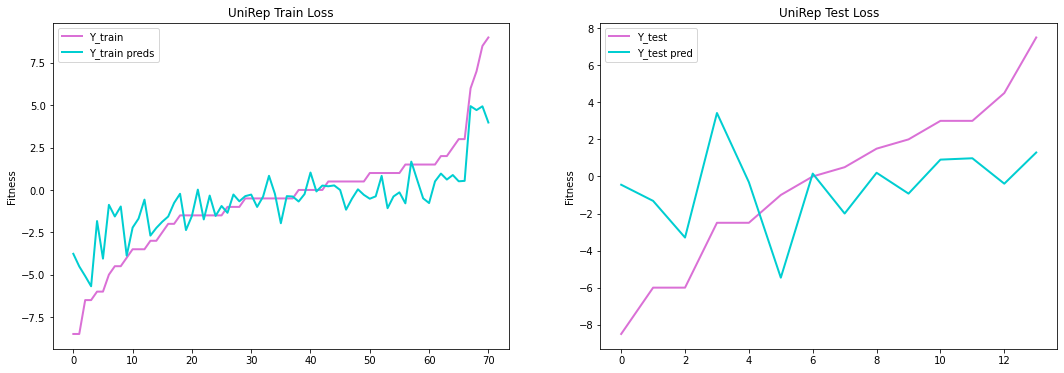

In [0]:
# test out our top model performance before running DE

rand_state_num = 1717

np.random.seed(rand_state_num)
rndperm = np.random.permutation(training_df.shape[0])

X_train = training_df.loc[rndperm[:train_batch_size], training_df.columns[2:]]
Y_train = training_df.loc[rndperm[:train_batch_size], "fitness"]
X_test = training_df.loc[rndperm[train_batch_size:int(1.2*train_batch_size)], training_df.columns[2:]]
Y_test = training_df.loc[rndperm[train_batch_size:int(1.2*train_batch_size)], "fitness"]


Y_train_preds = DE_model.predict(X_train)
Y_test_preds = DE_model.predict(X_test)

print("Train set ranking error: ", confusion_matrix_loss(np.array(Y_train),Y_train_preds))
print("Test set ranking error: ", confusion_matrix_loss(np.array(Y_test),Y_test_preds))

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1, title="UniRep Train Loss")
ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)],color="orchid",linewidth=2)
ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)],color="darkturquoise",linewidth=2)
ax1.set_ylabel("Fitness")
ax1.legend(['Y_train','Y_train preds'])

ax2 = fig.add_subplot(1,2,2, title="UniRep Test Loss")
ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color="orchid",linewidth=2)
ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color="darkturquoise",linewidth=2)
ax2.legend(['Y_test','Y_test pred'])
ax2.set_ylabel("Fitness")
plt.show()






##  Here we can actually run the DE with defined conditions

Mut loc:  258
Mut loc:  262
Mut loc:  268
Mut loc:  260
Mut loc:  268
Mut loc:  277
Mut loc:  277
Mut loc:  268
Mut loc:  252
finished trajectory # 0
Mut loc:  146
Mut loc:  143
Mut loc:  144
Mut loc:  141
Mut loc:  133
Mut loc:  130
Mut loc:  128
Mut loc:  116
finished trajectory # 1
Mut loc:  36
finished trajectory # 2
Mut loc:  133
Mut loc:  120
Mut loc:  137
Mut loc:  144
Mut loc:  136
Mut loc:  138
Mut loc:  130
Mut loc:  127
Mut loc:  133
Mut loc:  130
finished trajectory # 3
Mut loc:  83
Mut loc:  86
Mut loc:  86
Mut loc:  80
Mut loc:  63
Mut loc:  46
Mut loc:  39
Mut loc:  33
Mut loc:  27
finished trajectory # 4


<Figure size 432x288 with 0 Axes>

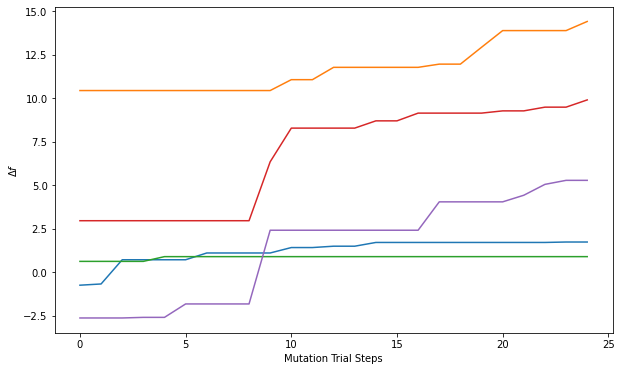

In [0]:


# define our wild-type sequence
s_wt = "MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRPSGYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQPSSRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAPQAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCANSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCS"

# define parameters of our DE simulation
DE_PROJECT_NAME = "PETase_high_N_eunirep"
T = 0.01
num_iterations = 25
num_trajectories = 5

# run the DE simulation
s_records, y_records = run_DE_trajectories(s_wt, DE_model, T, num_iterations, num_trajectories, DE_PROJECT_NAME, params ,save=True)

## Now we can try re-loading and plotting saved DE records and plotting

<Figure size 432x288 with 0 Axes>

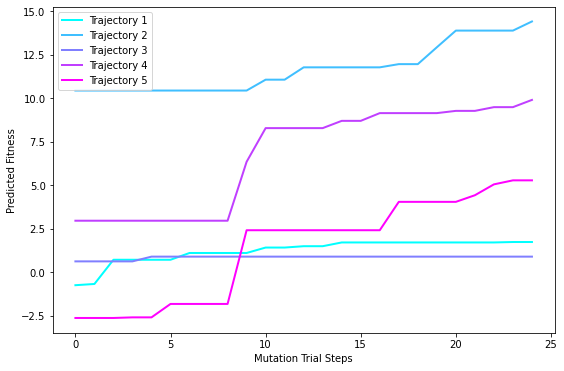

In [0]:
DE_PROJECT_NAME = "PETase_high_N_eunirep"
num_trajectories = 5

# to plot the trajectories of a given test:
plt.clf()
fig = plt.figure(figsize=(9,6))
label_list = []
color_idx = np.linspace(0, 1, num_trajectories)
for i,i_color in zip(list(np.arange(num_trajectories)),color_idx):
  traj_name = DE_PROJECT_NAME+"_traj"+str(i)
  seqs = np.loadtxt(gdrive_path+"DE_records/"+ traj_name + "_seqs.txt",dtype=str)
  fitness = np.loadtxt(gdrive_path+"DE_records/"+ traj_name + "_fitness.txt")
  plt.plot(fitness,color=plt.cm.cool(i_color),linewidth=2)
  label_list.append("Trajectory "+str(i+1))
plt.ylabel("Predicted Fitness")
plt.xlabel('Mutation Trial Steps')
plt.legend(label_list)
plt.show()

# to load the sequences from a given trajectory from a given test
seqs = np.loadtxt(gdrive_path+"DE_records/"+ traj_name + "_seqs.txt",dtype=str)

# Example: 2MS2

###Load Reps
Load representations of sequences stored in .feather format, then use those representations and corresponding labels to train a top model.

In [0]:
# load the reps you want into dataframes
FEATHER_PATH = gdrive_path + 'feathers/'

unirep_df = read_reps(FEATHER_PATH + '2MS2_unirep')
eunirep_df = read_reps(FEATHER_PATH + '2MS2_eunirep')
onehot_df = read_reps(FEATHER_PATH + '2MS2_one_hot')

dfs = [unirep_df, eunirep_df, onehot_df]
df_names = ['unirep', 'eunirep', 'one hot']

#### Load evotuned parameters, select evotuned dataframe, initialize predictive top-model

In [0]:
# load our choice of parameters, and load the top-model with specified alpha and batch size
training_df = dfs[1]
alpha = 1e-3
train_batch_size = 
param_file = "2MS2_weights/2MS2_1E5_iter_25"

params, DE_model = init_by_rep(training_df, alpha, train_batch_size, param_file) # choose eunirep representation, alpha=1e-3, and 96 training mutants

#### Make a plot to check how well the top model will perform

Train set ranking error:  0.17526785714285714
Test set ranking error:  0.375


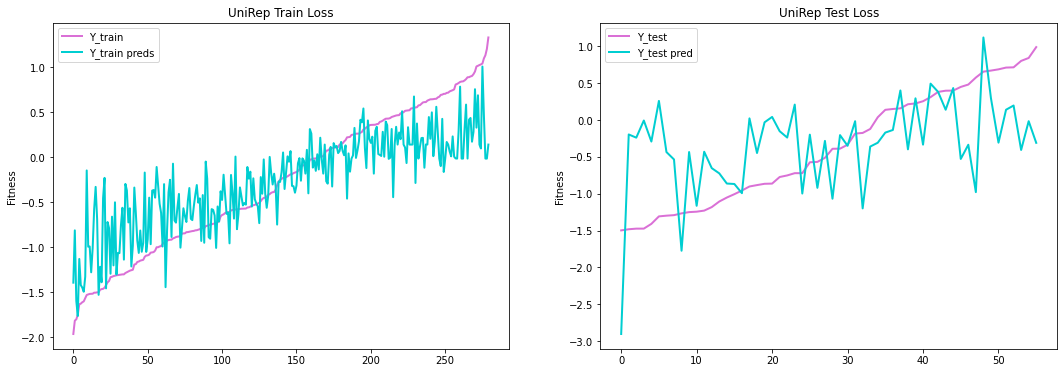

In [0]:
# test out our top model performance before running DE
np.random.seed(1717)

rndperm = np.random.permutation(training_df.shape[0])
X_train = training_df.loc[rndperm[:train_batch_size], training_df.columns[2:]]
Y_train = training_df.loc[rndperm[:train_batch_size], "fitness"]
X_test = training_df.loc[rndperm[train_batch_size:int(1.2*train_batch_size)], training_df.columns[2:]]
Y_test = training_df.loc[rndperm[train_batch_size:int(1.2*train_batch_size)], "fitness"]


Y_train_preds = DE_model.predict(X_train)
Y_test_preds = DE_model.predict(X_test)

print("Train set ranking error: ", confusion_matrix_loss(np.array(Y_train),Y_train_preds))
print("Test set ranking error: ", confusion_matrix_loss(np.array(Y_test),Y_test_preds))

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1, title="UniRep Train Loss")
ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)],color="orchid",linewidth=2)
ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)],color="darkturquoise",linewidth=2)
ax1.set_ylabel("Fitness")
ax1.legend(['Y_train','Y_train preds'])

ax2 = fig.add_subplot(1,2,2, title="UniRep Test Loss")
ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color="orchid",linewidth=2)
ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color="darkturquoise",linewidth=2)
ax2.legend(['Y_test','Y_test pred'])
ax2.set_ylabel("Fitness")
plt.show()






##  Here we can actually run the DE with defined conditions

Mut loc:  70
Mut loc:  61
Mut loc:  61
Mut loc:  60
Mut loc:  66
Mut loc:  76
Mut loc:  86
Mut loc:  87
Mut loc:  85
finished trajectory # 0
Mut loc:  55
Mut loc:  65
Mut loc:  66
Mut loc:  65
finished trajectory # 1
Mut loc:  102
Mut loc:  107
Mut loc:  103
finished trajectory # 2
Mut loc:  43
Mut loc:  46
Mut loc:  50
Mut loc:  51
finished trajectory # 3
Mut loc:  73
Mut loc:  75
Mut loc:  72
Mut loc:  59
Mut loc:  51
Mut loc:  60
Mut loc:  55
Mut loc:  63
Mut loc:  65
finished trajectory # 4


<Figure size 432x288 with 0 Axes>

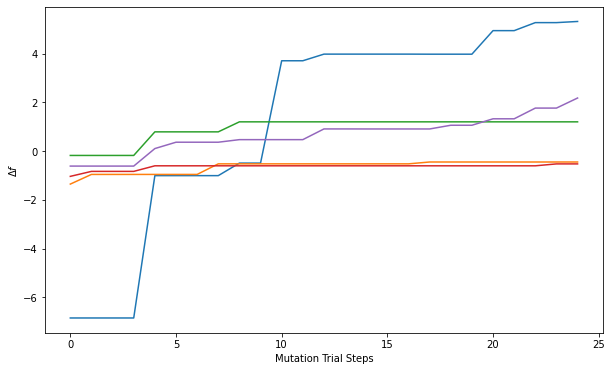

In [0]:


# define our wild-type sequence
s_wt = "ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTCSVRQSSAQNRKYTIKVEVPKVATQTVGGVELPVAAWRSYLNMELTIPIFATNSDCELIVKAMQGLLKDGNPIPSAIAANSGIY"

# define parameters of our DE simulation
DE_PROJECT_NAME = "2MS2_high_N_eunirep"
T = 0.01
num_iterations = 25
num_trajectories = 5

# run the DE simulation
s_records, y_records = run_DE_trajectories(s_wt, DE_model, T, num_iterations, num_trajectories, DE_PROJECT_NAME, params ,save=True)

## Now we can try re-loading and plotting saved DE records and plotting

<Figure size 432x288 with 0 Axes>

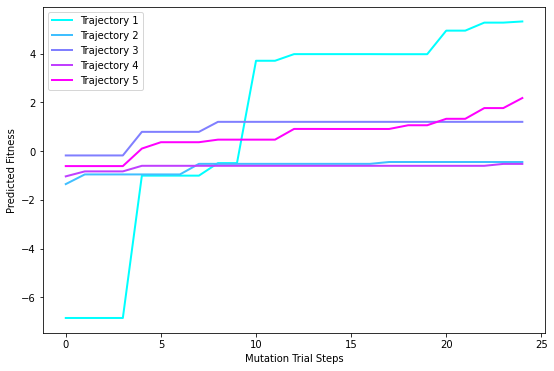

In [0]:
DE_PROJECT_NAME = "2MS2_high_N_eunirep"
num_trajectories = 5

# to plot the trajectories of a given test:
plt.clf()
fig = plt.figure(figsize=(9,6))
label_list = []
color_idx = np.linspace(0, 1, num_trajectories)
for i,i_color in zip(list(np.arange(num_trajectories)),color_idx):
  traj_name = DE_PROJECT_NAME+"_traj"+str(i)
  seqs = np.loadtxt(gdrive_path+"DE_records/"+ traj_name + "_seqs.txt",dtype=str)
  fitness = np.loadtxt(gdrive_path+"DE_records/"+ traj_name + "_fitness.txt")
  plt.plot(fitness,color=plt.cm.cool(i_color),linewidth=2)
  label_list.append("Trajectory "+str(i+1))
plt.ylabel("Predicted Fitness")
plt.xlabel('Mutation Trial Steps')
plt.legend(label_list)
plt.show()

# to load the sequences from a given trajectory from a given test
seqs = np.loadtxt(gdrive_path+"DE_records/"+ traj_name + "_seqs.txt",dtype=str)

# Example: TEM-1 Beta-lactamase

###Load Reps
Load representations of sequences stored in .feather format, then use those representations and corresponding labels to train a top model.

In [0]:
# load the reps you want into dataframes
FEATHER_PATH = gdrive_path + 'feathers/'

unirep_df = read_reps(FEATHER_PATH + 'BLAC_unirep')
eunirep_df = read_reps(FEATHER_PATH + 'BLAC_eunirep')
onehot_df = read_reps(FEATHER_PATH + 'BLAC_one_hot')

dfs = [unirep_df, eunirep_df, onehot_df]
df_names = ['unirep', 'eunirep', 'one hot']

#### Load evotuned parameters, select evotuned dataframe, initialize predictive top-model

In [0]:
# load our choice of parameters, and load the top-model with specified alpha and batch size
training_df = dfs[1]
alpha = 1e-3
train_batch_size = 240
param_file = "BLAC_weights/blac_unirep_global_init_1"

params, DE_model = init_by_rep(training_df, alpha, train_batch_size, param_file) # choose eunirep representation, alpha=1e-3, and 96 training mutants

#### Make a plot to check how well the top model will perform

Train set ranking error:  0.03302083333333333
Test set ranking error:  0.2717013888888889


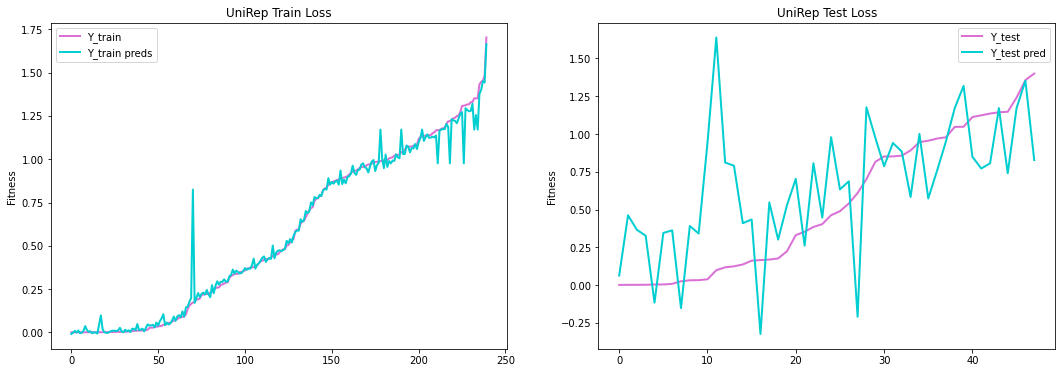

In [0]:
# test out our top model performance before running DE
np.random.seed(1717)
rndperm = np.random.permutation(training_df.shape[0])
X_train = training_df.loc[rndperm[:train_batch_size], training_df.columns[2:]]
Y_train = training_df.loc[rndperm[:train_batch_size], "fitness"]
X_test = training_df.loc[rndperm[train_batch_size:int(1.2*train_batch_size)], training_df.columns[2:]]
Y_test = training_df.loc[rndperm[train_batch_size:int(1.2*train_batch_size)], "fitness"]


Y_train_preds = DE_model.predict(X_train)
Y_test_preds = DE_model.predict(X_test)

print("Train set ranking error: ", confusion_matrix_loss(np.array(Y_train),Y_train_preds))
print("Test set ranking error: ", confusion_matrix_loss(np.array(Y_test),Y_test_preds))

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1, title="UniRep Train Loss")
ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)],color="orchid",linewidth=2)
ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)],color="darkturquoise",linewidth=2)
ax1.set_ylabel("Fitness")
ax1.legend(['Y_train','Y_train preds'])

ax2 = fig.add_subplot(1,2,2, title="UniRep Test Loss")
ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color="orchid",linewidth=2)
ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color="darkturquoise",linewidth=2)
ax2.legend(['Y_test','Y_test pred'])
ax2.set_ylabel("Fitness")
plt.show()






##  Here we can actually run the DE with defined conditions

In [0]:


# define our wild-type sequence
s_wt = "MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"

# define parameters of our DE simulation
DE_PROJECT_NAME = "BLAC_high_N_eunirep"
T = 0.01
num_iterations = 25
num_trajectories = 5

# run the DE simulation
s_records, y_records = run_DE_trajectories(s_wt, DE_model, T, num_iterations, num_trajectories, DE_PROJECT_NAME, params ,save=True)

Mut loc:  14
Mut loc:  4
Mut loc:  2
finished trajectory # 0
Mut loc:  183
Mut loc:  170
Mut loc:  192
Mut loc:  192
Mut loc:  210
finished trajectory # 1
Mut loc:  101
Mut loc:  94
Mut loc:  94
finished trajectory # 2
Mut loc:  87
Mut loc:  93
Mut loc:  67


RuntimeError: ignored

## Now we can try re-loading and plotting saved DE records and plotting

<Figure size 432x288 with 0 Axes>

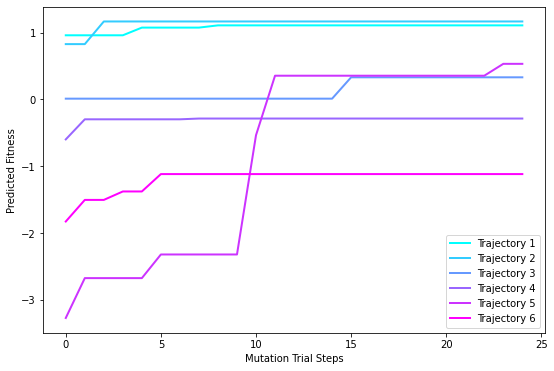

In [0]:
DE_PROJECT_NAME = "BLAC_high_N_eunirep"
num_trajectories = 5

# to plot the trajectories of a given test:
plt.clf()
fig = plt.figure(figsize=(9,6))
label_list = []
color_idx = np.linspace(0, 1, num_trajectories)
for i,i_color in zip(list(np.arange(num_trajectories)),color_idx):
  traj_name = DE_PROJECT_NAME+"_traj"+str(i)
  seqs = np.loadtxt(gdrive_path+"DE_records/"+ traj_name + "_seqs.txt",dtype=str)
  fitness = np.loadtxt(gdrive_path+"DE_records/"+ traj_name + "_fitness.txt")
  plt.plot(fitness,color=plt.cm.cool(i_color),linewidth=2)
  label_list.append("Trajectory "+str(i+1))
plt.ylabel("Predicted Fitness")
plt.xlabel('Mutation Trial Steps')
plt.legend(label_list)
plt.show()

# to load the sequences from a given trajectory from a given test
seqs = np.loadtxt(gdrive_path+"DE_records/"+ traj_name + "_seqs.txt",dtype=str)